In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
from datetime import datetime
import os
import sys
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

import astropy.stats as ast_stats

import pyflux as pf

import traces

import warnings
warnings.filterwarnings('ignore')
import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


from pykalman import KalmanFilter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

from sklearn.model_selection import TimeSeriesSplit

from scipy import integrate

from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq

import stldecompose

plt.rcParams['figure.figsize'] = (10, 8)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plotly_df(df, title = ''):
    data = []
    column = 'cpu'
    trace = go.Scatter(
        x = df.index,
        y = df.values,
        mode = 'lines',
        name = column
    )
    data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [3]:
def load_files_from_folder(files_name, col_name, root='./../Downloads/ciscoSwitch/attributes/'):
    datas = []
    for file in os.listdir(root):
        if os.path.isdir(os.path.join(root, file)):
            ip = file
            for fl in os.listdir(os.path.join(root, file)):
                cols = ['timestamp', col_name]

                df = pd.read_csv(
                    os.path.join(root,file,fl),
                    sep=',',
                    encoding='utf-8',
                    dtype='str',
                    names=cols
                )
                df['ip'] = ip
                datas.append(df)
    return pd.concat(datas, ignore_index=True, axis=0)

In [4]:
def split_date_and_set_week(df, col_name):
    mapping = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
    weeknum_mapping = {
        range(1,8):'0',
        range(8,15):'1',
        range(15,22):'2',
        range(22,29):'3',
        range(29,33):'4'
    }
    
    def set_weeknum(day):
        for k,v in weeknum_mapping.items():
            if day in k:
                return v
    
    df.timestamp = df.timestamp.astype(int)
    df['date'] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000000))
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    df['hour'] = df.date.apply(lambda x: x.hour)
    df['minute'] = df.date.apply(lambda x: x.minute)
    df['second'] = df.date.apply(lambda x: x.second)
    df['weekday'] = df.date.apply(lambda x: mapping[x.weekday()])
    df['weeknum'] = df.day.apply(set_weeknum)
    df['weekend'] = df.weekday.apply(lambda x: 1 if x == 'sat' or x == 'sun' else 0)
    df['busy'] = df.hour.apply(lambda x: 1 if 9<=x<18 else 0)
    df[col_name] = df[col_name].astype(int)
    return df

In [5]:
df_cpu = load_files_from_folder(files_name='cpuUtil', col_name='cpu')

In [ ]:
df_mem = load_files_from_folder(files_name='memUtil', col_name='mem')

## проба фильтра Калмана

In [ ]:
c = df_cpu[df_cpu.ip == '10.10.231.2']

In [ ]:
c = split_date_and_set_week(c, 'cpu')

In [ ]:
c.head(2)

In [ ]:
s = pd.Series(data=c['cpu'].values, index = c['date'].values)

### через pykalman

In [ ]:
kf = KalmanFilter(n_dim_state=2)
kk = kf.em(X=s.index.values, y=s.values, n_iter=30)

In [ ]:
filtered_state_estimates = kk.filter(s.values)[0]
filtered_state_smoothed = kk.smooth(s.values)[0]

In [ ]:
filtered = filtered_state_estimates[:,0]
smoothed = filtered_state_smoothed[:,0]

In [ ]:
smoothed[:5]

In [ ]:
s.index[:5]

In [ ]:
ss = pd.Series(data=s.index.astype(int).values)
pd.Series(data=smoothed, index=s.index.values)[20:800].plot(label='kalman')
# plt.plot(s[100:500].values, label='real')
# plt.legend()

In [ ]:
help(KalmanFilter)

### через scipy и велосипед

In [ ]:
# intial parameters
n_iter = s.shape[0]
sz = (n_iter,) # size of array
# x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)

z = s.values#numpy.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=numpy.zeros(sz)      # a posteri estimate of x
P=numpy.zeros(sz)         # a posteri error estimate
xhatminus=numpy.zeros(sz) # a priori estimate of x
Pminus=numpy.zeros(sz)    # a priori error estimate
K=numpy.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q
    
    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

pylab.figure()
pylab.plot(z,'k+',label='noisy measurements')
pylab.plot(xhat,'b-',label='a posteri estimate')
pylab.axhline(x,color='g',label='truth value')
pylab.legend()
pylab.xlabel('Iteration')
pylab.ylabel('Voltage')

pylab.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
pylab.xlabel('Iteration')
pylab.ylabel('$(Voltage)^2$')
pylab.setp(pylab.gca(),'ylim',[0,.01])


## выделим части из даты в данных

In [6]:
df_cpu = split_date_and_set_week(df_cpu, 'cpu')

In [7]:
df_cpu.head()

,timestamp,cpu,ip,date,year,month,day,hour,minute,second,weekday,weeknum,weekend,busy
0,1506805227529853,19,10.10.245.12,2017-10-01 00:00:27.529853,2017,10,1,0,0,27,sun,0,1,0
1,1506805527536264,18,10.10.245.12,2017-10-01 00:05:27.536264,2017,10,1,0,5,27,sun,0,1,0
2,1506805827551572,19,10.10.245.12,2017-10-01 00:10:27.551572,2017,10,1,0,10,27,sun,0,1,0
3,1506806127617002,18,10.10.245.12,2017-10-01 00:15:27.617002,2017,10,1,0,15,27,sun,0,1,0
4,1506809427715955,19,10.10.245.12,2017-10-01 01:10:27.715955,2017,10,1,1,10,27,sun,0,1,0


### Посмотрим на количество измерений и уникальность значений в измерениях

In [ ]:
ip = []
n = []
nunique = []
for k,v in df_cpu.groupby(['ip']):
    ip.append(k)
    n.append(v['timestamp'].count())
    nunique.append(v['cpu'].unique().shape[0])
    
unique_stat = pd.DataFrame()
unique_stat['ip'] = ip
unique_stat['n'] = n
unique_stat['nunique'] = nunique

In [ ]:
plt.figure(figsize=(10,5))
plt.title(u'Распределение уникальных значений')
sns.distplot(unique_stat['nunique'], bins=20)
median = unique_stat['nunique'].median()
plt.axvline(median, linestyle='--', color='g', label='median = {}'.format(median))
mean = unique_stat['nunique'].mean()
plt.axvline(mean, linestyle='--', color='y', label='mean = {}'.format(round(mean,2)))
moda = np.argmax(np.bincount(unique_stat['nunique']))
plt.axvline(moda, linestyle='--', color='r', label='moda = {}'.format(moda))
plt.legend()

In [ ]:
plt.figure(figsize=(10,5))
plt.title(u'Распределение числа измерений')
sns.distplot(unique_stat['n'], bins=20)
median = unique_stat['n'].median()
plt.axvline(median, linestyle='--', color='g', label='median = {}'.format(median))
mean = unique_stat['n'].mean()
plt.axvline(mean, linestyle='--', color='y', label='mean = {}'.format(round(mean,2)))
moda = np.argmax(np.bincount(unique_stat['n']))
plt.axvline(moda, linestyle='--', color='r', label='moda = {}'.format(moda))
plt.legend()

In [ ]:
print(unique_stat['nunique'].median())
print(unique_stat['nunique'].mean())
print()
print(unique_stat['n'].median())
print(unique_stat['n'].mean())

clazz = (unique_stat['n'] >= unique_stat['n'].median()) & (unique_stat['nunique'] >= unique_stat['nunique'].median())
unn = unique_stat.copy(deep=True)
unn['class'] = clazz.astype(int).values

# plt.figure(figsize=(17,8))
sns.lmplot(data=unn, x='n', y='nunique', hue='class', size=8, aspect=2, legend=False, scatter=True, logistic=False)
plt.xlabel(u'Количество измерений')
plt.ylabel(u'Количество уникальных значений в измерениях')
plt.axvline(unique_stat['n'].median(), color='g', linestyle='--', label='n median')
plt.axhline(unique_stat['nunique'].median(), color='g', linestyle='--', label='nunique median')
plt.legend()

### выделим один произвольный айпи. Сделаем timeSeries для тестов

In [ ]:
def create_one_ts(df, ip, col):
    return pd.Series(
    df.loc[df.ip == ip, col].values, 
    index=df.loc[df.ip == ip, 'date'].values)

In [ ]:
df_cpu.ip.unique()[:5]

In [ ]:
ip = '10.10.245.12'
ts_cpu = create_one_ts(df_cpu, ip, 'cpu')

In [ ]:
ts_cpu.plot(figsize=(17,8))

## Надо попробовать интерполировать ряд на постоянные промежутки

### посмотрим на что способна библиотека traces

resample на DataFrame лагал, а мб просто лень было разбираться, поэтому traces отлично подошла на роль интерполяции ряда

In [ ]:
def create_traces_ts(ts_cpu):
    import datetime as dd
    ii = ts_cpu.index
    return traces.TimeSeries([
        (
            dd.datetime(ii[i].year, ii[i].month, ii[i].day, ii[i].hour, ii[i].minute, ii[i].second), 
            ts_cpu[i]
        ) for i in range(ts_cpu.shape[0])])

def interpolate_ts(ts, interval=30):
    import datetime as dd
    ii = ts.index
    ts = create_traces_ts(ts)
    begin = ii[0]
    end = ii[-1]
    ss = ts.sample(
        sampling_period=dd.timedelta(minutes=interval),
        start=dd.datetime(begin.year, begin.month, begin.day, begin.hour),
        end=dd.datetime(end.year, end.month, end.day, end.hour),
        interpolate='linear',
    )
    return pd.Series(data=[i[1] for i in ss] , index=[i[0] for i in ss])

In [ ]:
ts_cpu_inter = interpolate_ts(ts_cpu,1)

In [ ]:
ts_cpu_inter.plot(figsize=(15,8))

### Если попробовать ARIMA(2,1,2)?

In [ ]:
ts_cpu.head()

In [ ]:
ts = ts_cpu.resample('5T')

In [ ]:
ts_is_null_index = ts.isnull()

In [ ]:
counter = 0
new_ts = ts.values
print(new_ts[:4])
for ix, i in enumerate(ts_is_null_index):
    if i:
        if counter < 4:
            new_ts[ix] = new_ts[ix-1]
            counter += 1 
        else:
            data = pd.DataFrame()
            data['cpu'] = new_ts[:ix]
            data.index = ts.index.values[:ix]

            model = pf.ARIMA(data=data, ar=2, ma=2, target='cpu', family=pf.Normal())
            x = model.fit('MLE')
            new_ts[ix] = model.predict(1).values[0]

In [ ]:
ts.head()

In [ ]:
data = pd.DataFrame()
data['cpu'] = ts_cpu_inter.values
data.index = ts_cpu_inter.index.values

In [ ]:
model = pf.ARIMA(data=data, ar=2, ma=2,integ=1, target='cpu', family=pf.Normal())

In [ ]:
ts_cpu_inter.plot(figsize=(17,8))

In [ ]:
x = model.fit('MLE')

In [ ]:
x.summary()

In [ ]:
model.plot_fit(figsize=(15,10))

### stl decomposition

In [ ]:
def plot_stl(ts):
    size = (15,7)
    stl_decomp = stldecompose.decompose(ts)
    plt.figure(figsize=size)
    plt.title('seasonal')
    stl_decomp.seasonal.plot()
    plt.figure(figsize=size)
    plt.title('trend')
    stl_decomp.trend.plot()
    plt.figure(figsize=size)
    plt.title('residual')
    stl_decomp.resid.plot()

In [ ]:
cpu_ts[:1000].plot()

In [ ]:
plot_stl(cpu_ts[:1000])

### Если посмотреть на процент значений больше или меньше определенных квантилей по всем устройствам

#### возьмем для начала процент значений по устройствам больше квантиля в 75 процентов

In [ ]:
ix = []
val = []
for k, v in df_cpu.groupby(['ip']):
    vv = v.loc[v['cpu'] > v['cpu'].quantile(.75), 'cpu'].count()/v['cpu'].count()*100
    ix.append(k)
    val.append(vv)
    
cpu_quantile_75 = pd.Series(data=val, index=ix)

plt.figure(figsize=(17,8))
plt.title(u'Процент значений больше квантиля в .75 по каждому устройству на всем времени съема показаний')
cpu_quantile_75.sort_values().plot(label=u'значения в процентах')
plt.grid(True)
plt.axhline(y=cpu_quantile_75.mean()+cpu_quantile_75.std(), color='green', linestyle='--')
plt.axhline(y=cpu_quantile_75.mean()-cpu_quantile_75.std(), color='green', linestyle='--')

cc = cpu_quantile_75.count()
threshold = cpu_quantile_75.mean()+cpu_quantile_75.std()
plt.axvline(x =cc -(cpu_quantile_75.sort_values() > threshold).sum(),
        linestyle='--')

plt.legend()

cc -(cpu_quantile_75.sort_values() > threshold).sum()

In [ ]:
ix = []
val = []
for k, v in df_cpu.groupby(['ip']):
    vv = v.loc[v['cpu'] < v['cpu'].quantile(.25), 'cpu'].count()/v['cpu'].count()*100
    ix.append(k)
    val.append(vv)
    
cpu_quantile_25 = pd.Series(data=val, index=ix)


plt.figure(figsize=(17,8))
plt.title(u'Процент значений меньше квантиля в .25 по каждому устройству на всем времени съема показаний')
cpu_quantile_25.sort_values().plot(label=u'значения в процентах')
plt.grid(True)
plt.axhline(y=cpu_quantile_25.mean()+cpu_quantile_25.std(), color='green', linestyle='--')
plt.axhline(y=cpu_quantile_25.mean()-cpu_quantile_25.std(), color='green', linestyle='--')
cc = cpu_quantile_25.count()
threshold = cpu_quantile_25.mean()+cpu_quantile_25.std()
plt.axvline(x =cc -(cpu_quantile_25.sort_values() > threshold).sum(),
        linestyle='--')
plt.legend()

cc -(cpu_quantile_25.sort_values() > threshold).sum()

In [ ]:
cpu_quantile_25[:4]

In [ ]:
cpu_quantile_75[:4]

In [ ]:
dd = pd.DataFrame()
dd['< quantile(.25), %'] = cpu_quantile_25.values
dd['> quantile(.75), %'] = cpu_quantile_75.values

In [ ]:
sns.jointplot(data=dd, x='< quantile(.25), %', y='> quantile(.75), %', kind='kde', size=8, aspect=2)

In [ ]:
quantiles = pd.DataFrame()
quantiles['q25'] = cpu_quantile_25.values
quantiles['q75'] = cpu_quantile_75.values
quantiles['ip'] = cpu_quantile_25.index

In [ ]:
sns.regplot(data=quantiles, x='q25', y='q75')

#  Посмотрим на аггрегацию данных

In [ ]:
unn.head()

In [ ]:
valid_ip = unn[unn['class']==1]

In [ ]:
ipps = valid_ip.sort_values(by='nunique', ascending=False).ip.values[:5]

In [ ]:
datas = {
    'cpuUtil':[],
    'memUtil':[],
    'inUtil':[],
    'outUtil':[]
}

def load_data_by_ip(root = './../../anton/Desktop/rostel/ciscoSwitch/', ips='123'):
    global datas
    for file in os.listdir(root):
        ip_folder = False
        try:
            mb_ip = file.split('.')
            if len(mb_ip) == 4 and file in ips:
                ip_folder = True
            else:
                ip_folder = False
        except:
            pass
        if ip_folder and os.path.isdir(os.path.join(root, file)):
            new_root = os.path.join(root, file)
            for f in os.listdir(new_root):
                for k, v in datas.items():
                    if k in f:
                        df = pd.read_csv(
                            os.path.join(new_root, f),
                            sep=',',
                            encoding='utf-8',
                            dtype='str',
                            names = ['timestamp', 'val']
                        )
                        df['ip'] = file
                        v.append(df)
        else:
            if os.path.isdir(os.path.join(root, file)):
                load_data_by_ip(os.path.join(root, file), ips)

In [ ]:
load_data_by_ip(
    root='./../../anton/Desktop/rostel/ciscoSwitch/',
    ips=valid_ip.sort_values(by='nunique', ascending=False).ip.values[:5]
)

In [ ]:
def prep_df():
    global datas
    mapping = {'cpuUtil':'cpu', 'memUtil':'mem', 'inUtil':'in', 'outUtil':'out'}
    dfs = {}
    for k,v in datas.items():
        tmp_df = pd.concat(v, axis=0, ignore_index=True)
        tmp_df.columns = ['timestamp', mapping[k], 'ip']
        dfs[k] = tmp_df
    return dfs

In [ ]:
df = prep_df()

In [ ]:
del datas

In [ ]:
for k,v in df.items():
    print(k)
    print(v['ip'].unique())

In [ ]:
def get_dfs(ip, df):
    cpu = df['cpuUtil']
    cpu = cpu[cpu.ip == ip]
    cpu['cpu'] = cpu['cpu'].astype(int)

    mem = df['memUtil']
    mem = mem[mem.ip == ip]
    mem['mem'] = mem['mem'].astype(int)

    inn = df['inUtil']
    inn = inn[inn.ip == ip]
    inn['in'] = inn['in'].astype(float)

    out = df['outUtil']
    out = out[out.ip == ip]
    out['out'] = out['out'].astype(float)
    
    return cpu, mem, inn, out

In [ ]:
valid_ip.sort_values(by='nunique', ascending=False).ip.values[:5]

In [ ]:
def split_time(cpu):
    cpu['datestamp'] = cpu.timestamp.astype(int).apply(lambda x: datetime.fromtimestamp(x/1000000))
    cpu['date'] = cpu['datestamp'].astype(str).apply(lambda x: x.split(' ')[0])
    cpu['time'] = cpu['datestamp'].astype(str).apply(lambda x: x.split(' ')[1])
    cpu['hour'] = cpu.datestamp.apply(lambda x: x.hour)
    cpu['minute'] = cpu.datestamp.apply(lambda x: x.minute)
    cpu['h:m'] = cpu['time'].apply(lambda x: ':'.join(x.split('.')[0].split(':')[:2]))
    
    return cpu

In [ ]:
cpus = []
# mems = []
ins = []
outs = []
for ip in valid_ip.sort_values(by='nunique', ascending=False).ip.values[:5]:
    cpu, mem, inn, out = get_dfs(ip,df)
    cpu = split_time(cpu)
    mem = split_time(mem)
    inn = split_time(inn)
    out = split_time(out)
    hour_intersect = set(cpu['hour']) & set(inn['hour']) & set(out['hour'])
    date_intersect = set(cpu['date']) & set(inn['date']) & set(out['date'])
    c =cpu[(cpu.hour.isin(list(hour_intersect)))&(cpu.date.isin(list(date_intersect)))]
    cpus.append(c)
    c =inn[(inn.hour.isin(list(hour_intersect)))&(inn.date.isin(list(date_intersect)))]
    ins.append(c)
    c =out[(out.hour.isin(list(hour_intersect)))&(out.date.isin(list(date_intersect)))]
    outs.append(c)

In [ ]:
cpus = pd.concat(cpus, axis=0, ignore_index=True)
ins = pd.concat(ins, axis=0, ignore_index=True)
outs = pd.concat(outs, axis=0, ignore_index=True)

In [ ]:
del df

In [ ]:
cpus.head()

In [ ]:
def split_date_and_set_week(df, col_name):
    mapping = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
    weeknum_mapping = {
        range(1,8):'0',
        range(8,15):'1',
        range(15,22):'2',
        range(22,29):'3',
        range(29,33):'4'
    }
    
    def set_weeknum(day):
        for k,v in weeknum_mapping.items():
            if day in k:
                return v
    
    df['year'] = df.datestamp.apply(lambda x: x.year)
    df['month'] = df.datestamp.apply(lambda x: x.month)
    df['day'] = df.datestamp.apply(lambda x: x.day)
    df['second'] = df.datestamp.apply(lambda x: x.second)
    df['weekday'] = df.datestamp.apply(lambda x: mapping[x.weekday()])
    df['weeknum'] = df.datestamp.apply(set_weeknum)
    df['weekend'] = df.datestamp.apply(lambda x: 1 if x == 'sat' or x == 'sun' else 0)
    df['busy'] = df.hour.apply(lambda x: 1 if 9<=x<18 else 0)
    df[col_name] = df[col_name].astype(int)
    return df

In [ ]:
cpus = split_date_and_set_week(cpus, 'cpu')

In [ ]:
ins = split_date_and_set_week(ins, 'in')

In [ ]:
outs = split_date_and_set_week(outs, 'out')

In [ ]:
cpus.ip.unique()

In [ ]:
c = cpus[cpus.ip == '10.10.231.2']
i = ins[ins.ip == '10.10.231.2']

In [ ]:
plt.plot(c['cpu'])

In [ ]:
i['in'].unique()

In [ ]:
import scipy
g = sns.JointGrid(x=c['cpu'], y=i['in'])
g = g.plot_joint(plt.scatter, edgecolor="white", color='b', alpha=.4)
_ = g.ax_marg_x.hist(c['cpu'], color='r', bins=30, alpha=.2)
_ = g.ax_marg_y.hist(i['in'],  orientation="horizontal", bins=30, color='g', alpha=.2)
g = g.annotate(scipy.stats.pearsonr)

In [ ]:
c = cpus[cpus.ip == '10.10.231.2']
o = outs[outs.ip == '10.10.231.2']

In [ ]:
import scipy
g = sns.JointGrid(x=c['cpu'], y=o['out'])
g = g.plot_joint(plt.scatter, edgecolor="white", color='b', alpha=.4)
_ = g.ax_marg_x.hist(c['cpu'], color='r', bins=30, alpha=.2)
_ = g.ax_marg_y.hist(o['out'],  orientation="horizontal", bins=30, color='g', alpha=.2)
g = g.annotate(scipy.stats.pearsonr)

In [ ]:
i = ins[ins.ip == '10.10.231.2']
o = outs[outs.ip == '10.10.231.2']

In [ ]:
g = sns.JointGrid(x=i['in'], y=o['out'])
g = g.plot_joint(plt.scatter, edgecolor="white", color='b', alpha=.4)
_ = g.ax_marg_x.hist(i['in'], color='r', bins=30, alpha=.2)
_ = g.ax_marg_y.hist(o['out'],  orientation="horizontal", bins=30, color='g', alpha=.2)
g = g.annotate(scipy.stats.pearsonr)

In [ ]:
cpu['datestamp'] = cpu.timestamp.astype(int).apply(lambda x: datetime.fromtimestamp(x/1000000))
cpu['date'] = cpu['datestamp'].astype(str).apply(lambda x: x.split(' ')[0])
cpu['time'] = cpu['datestamp'].astype(str).apply(lambda x: x.split(' ')[1])
cpu['hour'] = cpu.datestamp.apply(lambda x: x.hour)
cpu['minute'] = cpu.datestamp.apply(lambda x: x.minute)
cpu['h:m'] = cpu['time'].apply(lambda x: ':'.join(x.split('.')[0].split(':')[:2]))

In [ ]:
cpu.head()

In [ ]:
frequency, power = ast_stats.LombScargle(cpu['timestamp'][:5].astype(int), cpu['cpu'][:5]).autopower()

In [ ]:
rr = (cpu.minute - cpu.minute.shift(1).fillna(0))
rr[rr == -55] = 5
rr.plot()

In [ ]:
rr.shape[0]

In [ ]:
(rr == 5).sum()

In [ ]:
out['datestamp'] = out.timestamp.astype(int).apply(lambda x: datetime.fromtimestamp(x/1000000))
out['date'] = out['datestamp'].astype(str).apply(lambda x: x.split(' ')[0])
out['time'] = out['datestamp'].astype(str).apply(lambda x: x.split(' ')[1])
out['hour'] = out.datestamp.apply(lambda x: x.hour)
out['minute'] = out.datestamp.apply(lambda x: x.minute)
out['h:m'] = out['time'].apply(lambda x: ':'.join(x.split('.')[0].split(':')[:2]))

In [ ]:
out.head()

In [ ]:
rr = (inn.minute - inn.minute.shift(1).fillna(0))
rr[rr == -55] = 5
rr.plot()

In [ ]:
inn['datestamp'] = inn.timestamp.astype(int).apply(lambda x: datetime.fromtimestamp(x/1000000))
inn['date'] = inn['datestamp'].astype(str).apply(lambda x: x.split(' ')[0])
inn['time'] = inn['datestamp'].astype(str).apply(lambda x: x.split(' ')[1])
inn['hour'] = inn.datestamp.apply(lambda x: x.hour)
inn['minute'] = inn.datestamp.apply(lambda x: x.minute)
inn['h:m'] = inn['time'].apply(lambda x: ':'.join(x.split('.')[0].split(':')[:2]))

In [ ]:
inn.head()

In [ ]:
rr = (inn.minute - inn.minute.shift(1).fillna(0))
rr[rr == -55] = 5
rr.plot()

In [ ]:
rr.shape[0]

In [ ]:
(rr == 5).sum()

In [ ]:
hour_intersect = set(cpu['hour']) & set(inn['hour']) & set(out['hour'])
date_intersect = set(cpu['date']) & set(inn['date']) & set(out['date'])

In [ ]:
len(date_intersect)

In [ ]:
c = cpu[(cpu.date.isin(list(date_intersect))) & (cpu.hour.isin(list(hour_intersect)))]
i = inn[(inn.date.isin(list(date_intersect))) & (inn.hour.isin(list(hour_intersect)))]
o = out[(out.date.isin(list(date_intersect))) & (out.hour.isin(list(hour_intersect)))]

In [ ]:
print(c.shape)
print(i.shape)
print(o.shape)

In [ ]:
cpu_ts = pd.Series(data=c['cpu'].values, index=c['datestamp'].values)
in_ts = pd.Series(data=i['in'].values, index=i['datestamp'].values)
out_ts = pd.Series(data=o['out'].values, index=o['datestamp'].values)

In [ ]:
cpu_ts.plot(figsize=(17,8))
in_ts.plot(figsize=(17,8))
out_ts.plot(figsize=(17,8))

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scaler = StandardScaler()

In [ ]:
a = std_scaler.fit_transform(cpu_ts.reshape(-1,1))

In [ ]:
a[:,0]

In [ ]:
cpu_ts_scl = pd.Series(data=std_scaler.fit_transform(cpu_ts.reshape(-1,1))[:,0], index=cpu_ts.index)
in_ts_scl = pd.Series(data=std_scaler.fit_transform(in_ts.reshape(-1,1))[:,0], index=in_ts.index)
out_ts_scl = pd.Series(data=std_scaler.fit_transform(out_ts.reshape(-1,1))[:,0], index=out_ts.index)
# mem_ts_scl = std_scaler.fit_transform(mem_ts.reshape(-1,1))

In [ ]:
slc = 300
# plt.figure(figsize=(17,8))
cpu_ts_scl[:220].plot(figsize=(20,12), label='cpu')
in_ts_scl[:200].plot(label='inUtil', linestyle='--')
out_ts_scl[:100].plot(label='outUtil', linestyle='-.')
plt.legend()

In [ ]:
cpu_ts[:1000].plot(figsize=(17,8))
in_ts[:1000].plot(figsize=(17,8))

In [ ]:
cpu_ts[:500].plot(figsize=(17,8))
in_ts[:500].plot(figsize=(17,8))

In [ ]:
cpu_ts[:100].plot(figsize=(17,8))
in_ts[:100].plot(figsize=(17,8))

In [ ]:
g = sns.JointGrid(x=cpu['cpu'], y=inn['in'])
g = g.plot_joint(plt.scatter, edgecolor="white", color='b', alpha=.4)
_ = g.ax_marg_x.hist(cpu['cpu'], color='r', bins=30, alpha=.2)
_ = g.ax_marg_y.hist(inn['in'],  orientation="horizontal", bins=30, color='g', alpha=.2)

In [ ]:
sns.jointplot(x=cpu['cpu'], y=inn['in'], kind='kde')

In [ ]:
plt.figure()
sns.distplot(cpu['cpu'].astype(int))
plt.figure()
sns.distplot(mem['mem'].astype(int))
plt.figure()
sns.distplot(inn['in'].astype(float))
plt.figure()
sns.distplot(out['out'].astype(float))



## Попытка соединить cpu и mem для совместного анализа. Что-то комп умирает :(

In [ ]:
ips = set(cpuUtil.ip.unique()) & set(memUtil.ip.unique())

In [ ]:
len(ips)

In [ ]:
mem_ips = memUtil[memUtil.ip.isin(ips)]

In [ ]:
ip_quantile_751 = ip_quantile_75.sort_values('index')

In [ ]:
mem_ip_quantile_75.shape

In [ ]:
cpu_mem = pd.DataFrame(index=ip_quantile_75.index)
cpu_mem['cpu'] = ip_quantile_75
cpu_mem['mem'] = mem_ip_quantile_75

In [ ]:
cpu_mem[cpu_mem.mem.isnull()].head()

In [ ]:
cpu_mem.dropna().corr()

In [ ]:
mem_ip_quantile_75[mem_ip_quantile_75>25].count()

In [ ]:
cpuUtil.shape

In [ ]:
(cpuUtil.busy == 1).sum()

## Визуализируем данные в разрезах

In [8]:
df_cpu.head()

,timestamp,cpu,ip,date,year,month,day,hour,minute,second,weekday,weeknum,weekend,busy
0,1506805227529853,19,10.10.245.12,2017-10-01 00:00:27.529853,2017,10,1,0,0,27,sun,0,1,0
1,1506805527536264,18,10.10.245.12,2017-10-01 00:05:27.536264,2017,10,1,0,5,27,sun,0,1,0
2,1506805827551572,19,10.10.245.12,2017-10-01 00:10:27.551572,2017,10,1,0,10,27,sun,0,1,0
3,1506806127617002,18,10.10.245.12,2017-10-01 00:15:27.617002,2017,10,1,0,15,27,sun,0,1,0
4,1506809427715955,19,10.10.245.12,2017-10-01 01:10:27.715955,2017,10,1,1,10,27,sun,0,1,0


In [9]:
def extract_ips(df, ip_count):
    ips = df.ip.unique()[:ip_count]
    return ips, df[df.ip.isin(ips)]

In [19]:
ips, df = extract_ips(df_cpu, 5)

In [11]:
df.columns

Index(['timestamp', 'cpu', 'ip', 'date', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'weekday', 'weeknum', 'weekend', 'busy'],
      dtype='object')

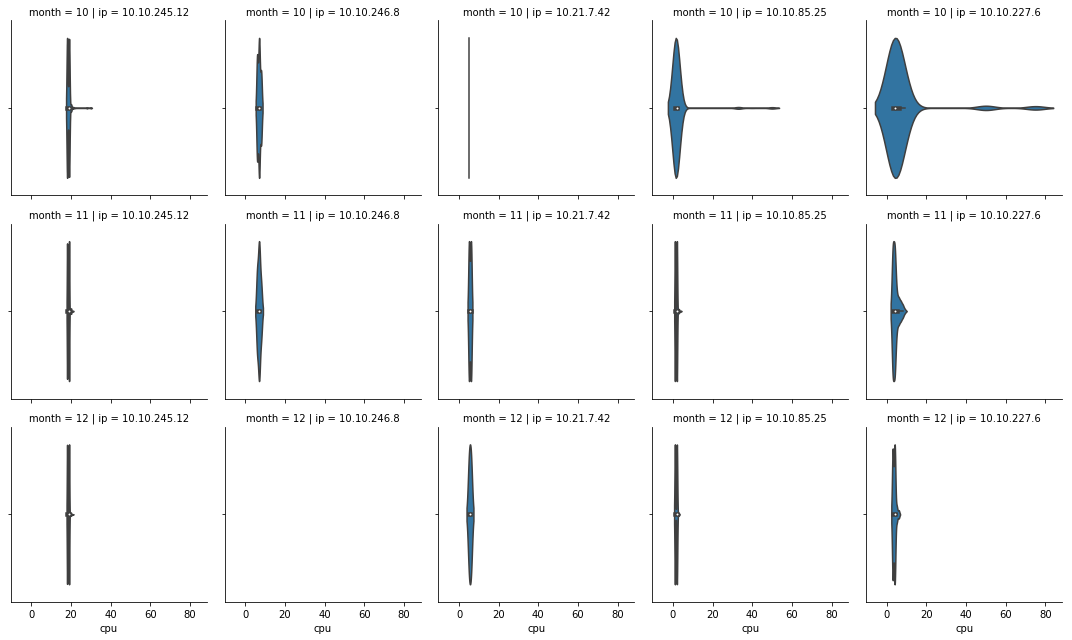

In [12]:
g= sns.FacetGrid(df, row='month', col='ip')
g.map(sns.violinplot, 'cpu')

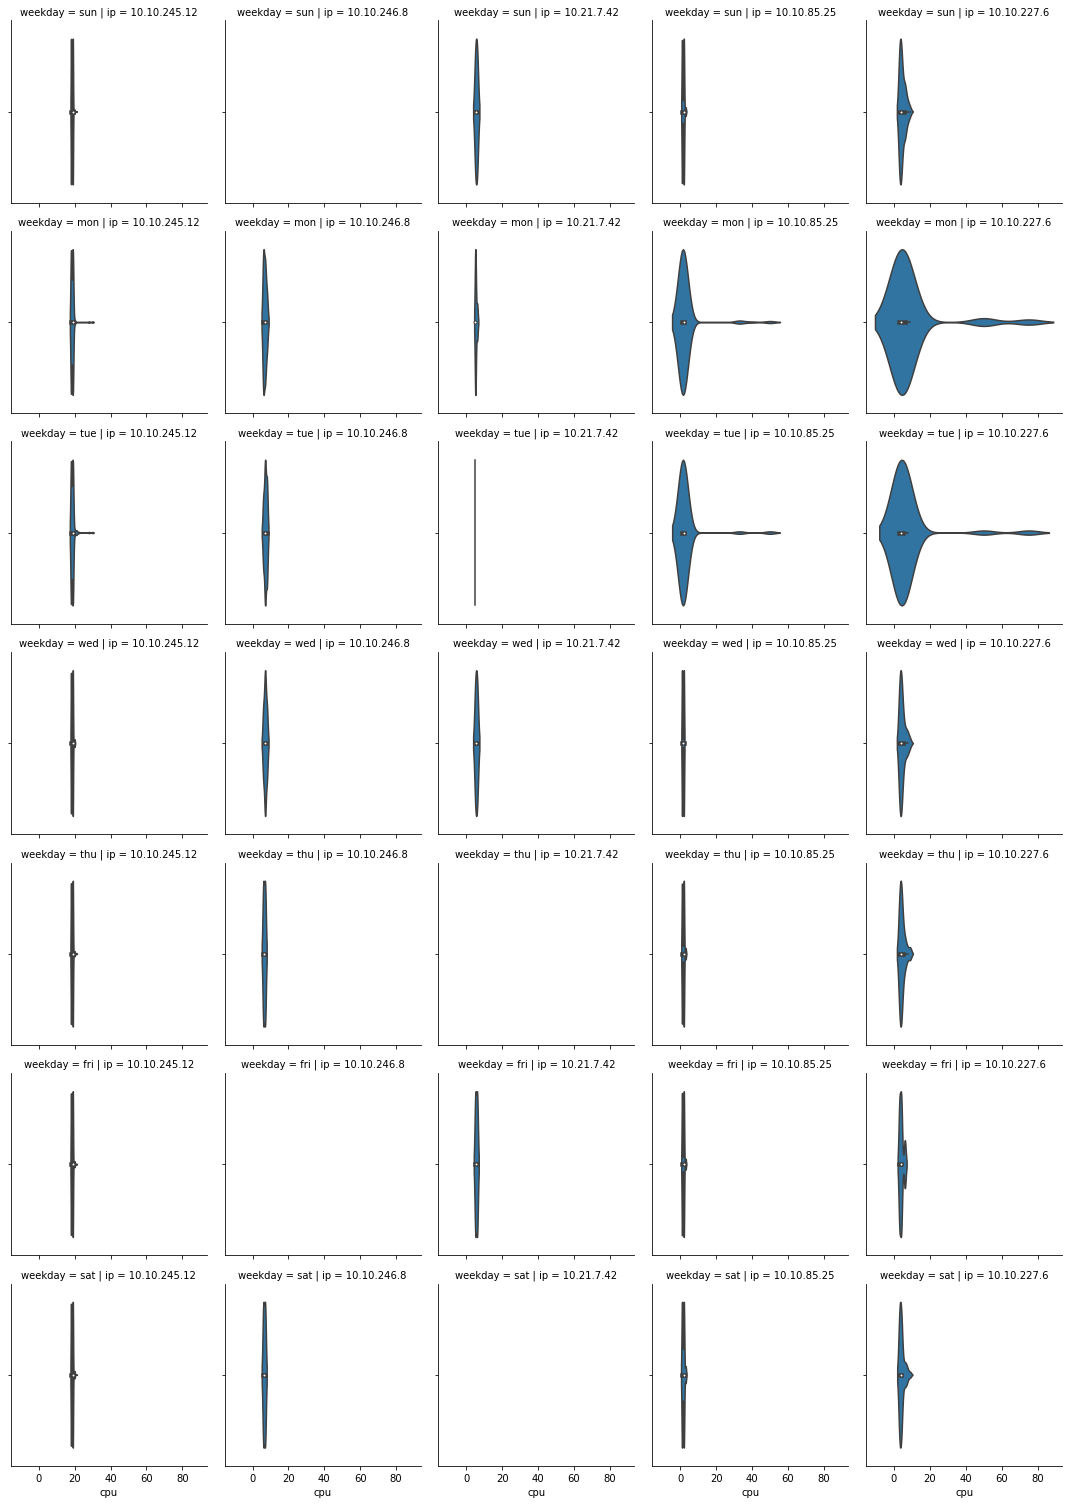

In [14]:
g= sns.FacetGrid(df, row='weekday', col='ip')
g.map(sns.violinplot, 'cpu')
g.savefig('./../Desktop/weekday.png')

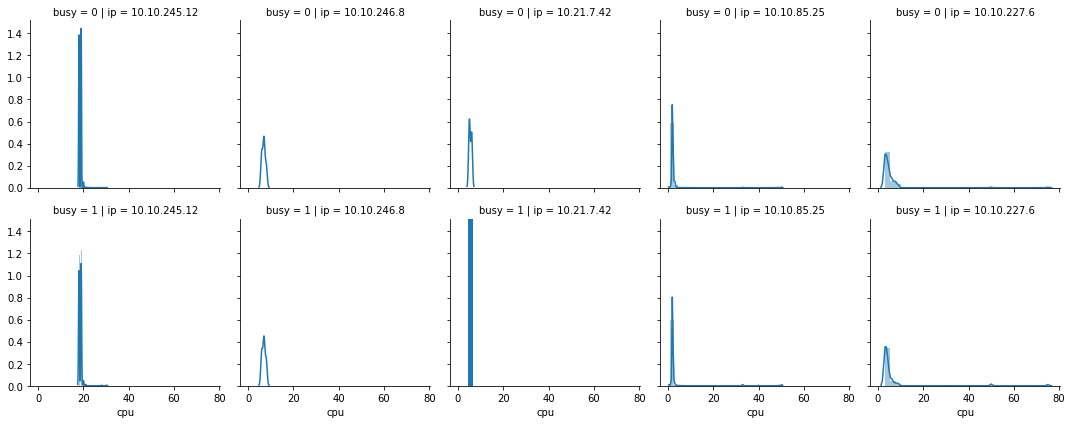

In [20]:
g= sns.FacetGrid(df, row='busy', col='ip')
g.map(sns.distplot,'cpu', bins=30)
g.savefig('./../Desktop/busy.png')

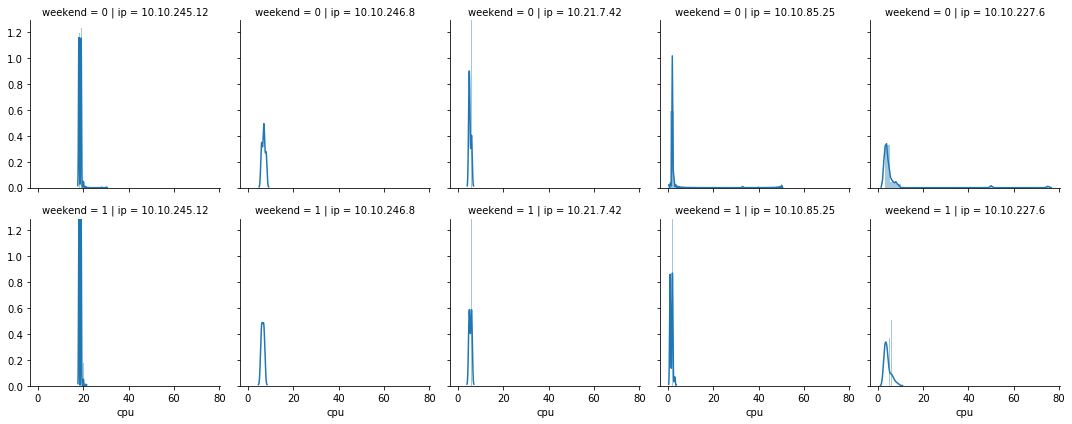

In [16]:
g= sns.FacetGrid(df, row='weekend', col='ip')
g.map(sns.distplot,'cpu', bins=30)
g.savefig('./../Desktop/weekend.png')

In [ ]:
g= sns.FacetGrid(df, row='ip', size=6, aspect=5)
g.map(sns.boxplot,'day','cpu')

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, x='hour', y='cpu', hue='ip')

In [ ]:
g=sns.FacetGrid(df, row='weekday', col='ip')
g.map(sns.violinplot,'cpu')

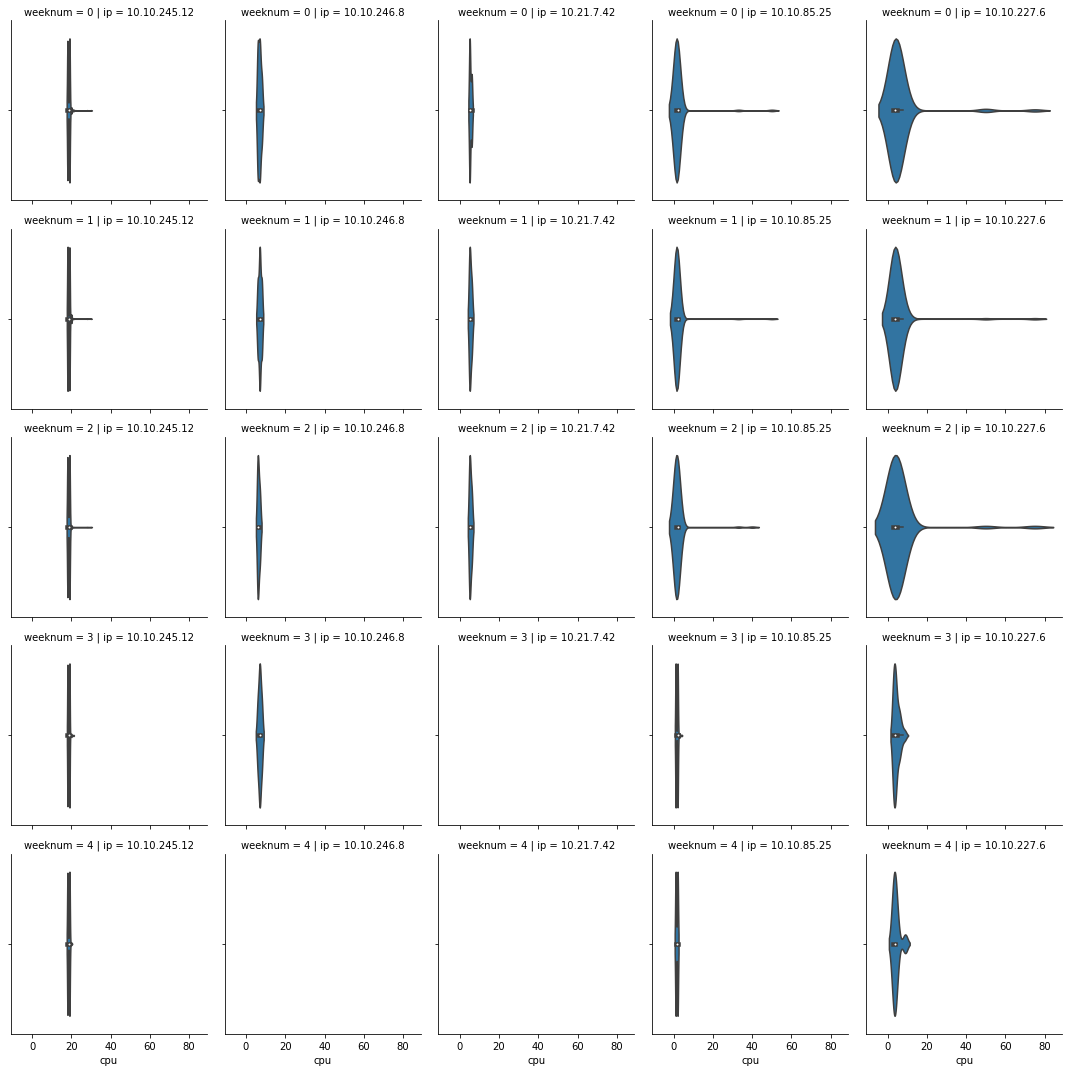

In [22]:
g=sns.FacetGrid(df, row='weeknum', col='ip')
g.map(sns.violinplot,'cpu')
g.savefig('./../Desktop/weeknum.png')

### Применение pyflux для проверки ARMA моделей

In [ ]:
data = pd.DataFrame()
data['cpu'] = ts_cpu_inter.values
data.index = ts_cpu_inter.index.values

In [ ]:
model = pf.ARIMA(data=data, ar=4, ma=4,integ=1, target='cpu', family=pf.Normal())

In [ ]:
ts_cpu_inter.plot(figsize=(17,8))

In [ ]:
x = model.fit('MLE')

In [ ]:
x.summary()

In [ ]:
model.plot_z(figsize=(17,7))

In [ ]:
model.plot_fit(figsize=(15,10))

In [ ]:
# plotly_df(ts_cpu_inter, title = 'ff')

In [ ]:
ts_cpu_inter.hist()

In [ ]:
from scipy import signal
fs = 10e1
f, Pxx_den = signal.periodogram(cpu_ts[:100], fs)
plt.figure(figsize=(25,15))
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
FD = 22050 # частота дискретизации, отсчётов в секунду
# а это значит, что в дискретном сигнале представлены частоты от нуля до 11025 Гц (это и есть теорема Котельникова)
N = ts_cpu_inter.shape[0]
print(N)
spectrum = rfft(ts_cpu)
print(spectrum.shape)

plt.figure(figsize=(17,8))
plt.plot(np_abs(spectrum))
# plt.plot(rfftfreq(N, 1./FD), np_abs(spectrum)/N)
plt.xlabel(u'Частота, Гц')
plt.ylabel(u'Амплитуда')
plt.ylim([-1,160])
plt.title(u'Спектр')
plt.grid(True)
plt.show()

### Попробуем кластеризацию

In [ ]:
def get_freq(vals, col, freq):
    try:
        frequency, power = ast_stats.LombScargle(v['timestamp'][:100].astype(int), v[col][:100]).autopower()
        return frequency[freq]
    except:
        return 0
    
def get_amp(v, col, freq):
    try:
        frequency, power = ast_stats.LombScargle(v['timestamp'][:100].astype(int), v[col][:100]).autopower()
        return power[freq]
    except:
        return 0
    
def get_weeked_day_high(vv,col):
    mapping = {'sat':5, 'sun':6, 'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4}
    rev_map = {v:k for k,v in mapping.items()}
    
    mask = vv[col] > vv[col].quantile(0.75)
    try:
        return rev_map[np.argmax(np.bincount(vv.loc[mask, 'weekday'].map(mapping)))]
    except:
        return 'no_day'

def get_weeked_day_low(vv, col):
    mapping = {'sat':5, 'sun':6, 'mon':0, 'tue':1, 'wed':2, 'thu':3, 'fri':4}
    rev_map = {v:k for k,v in mapping.items()}
    
    mask = vv[col] < vv[col].quantile(0.25)
    try:
        return rev_map[np.argmax(np.bincount(vv.loc[mask, 'weekday'].map(mapping)))]
    except:
        return 'no_day'
    
def ftrs_engine(cpu, preffix):
    clust_data = pd.DataFrame()
    clust_data['{}_week_day_high'.format(preffix)] = cpu.groupby('ip').apply(lambda v: get_weeked_day_high(v,preffix))
    clust_data['{}_week_day_low'.format(preffix)] = cpu.groupby('ip').apply(lambda v: get_weeked_day_low(v, preffix))

    clust_data['{}_mean'.format(preffix)] = cpu.groupby('ip')[[preffix]].mean()
    clust_data['{}_median'.format(preffix)] = cpu.groupby('ip')[[preffix]].median()
    clust_data['{}_std'.format(preffix)] = cpu.groupby('ip')[[preffix]].std()
    clust_data['{}_moda'.format(preffix)] = cpu.groupby('ip').apply(lambda v: np.argmax(np.bincount(v[preffix])))
    clust_data['{}_q25'.format(preffix)] = cpu.groupby('ip').apply(lambda v: v[preffix].quantile(.25))
    clust_data['{}_q75'.format(preffix)] = cpu.groupby('ip').apply(lambda v: v[preffix].quantile(.75))
    clust_data['{}_min'.format(preffix)] = cpu.groupby('ip')[[preffix]].min()
    clust_data['{}_max'.format(preffix)] = cpu.groupby('ip')[[preffix]].max()
    clust_data['{}_integ'.format(preffix)] = cpu.groupby('ip').apply(lambda v: integrate.simps(y=v[preffix].values)/v[preffix].count())
    for lag in range(1,10):
        clust_data['{}_lag{}'.format(preffix,lag)] = cpu.groupby('ip').apply(lambda v: v[preffix].autocorr(lag=lag))

    clust_data['{}_ratio'.format(preffix)] = cpu.groupby('ip').apply(lambda v: v[preffix].count()/cpu[preffix].count())


    for freq in range(1,15):
        clust_data['{}_freq{}'.format(preffix,freq)] = cpu.groupby('ip').apply(lambda v: get_freq(v, preffix, freq))
        clust_data['{}_freq{}_amp{}'.format(preffix,freq, freq)] = cpu.groupby('ip').apply(lambda v: get_amp(v, preffix, freq))
    return clust_data

In [ ]:
cpu.ip.unique()

In [ ]:
clust_data = ftrs_engine(cpu, 'cpu')

In [ ]:
clust_data.cpu_freq1_amp1

In [ ]:
clust_data.info()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
tt = pd.get_dummies(clust_data.select_dtypes(include='object'))

In [ ]:
clust_data.head()

In [ ]:
tt.head()

In [ ]:
clust_d = pd.concat([clust_data, tt], axis=1)

In [ ]:
clust_d.drop(['cpu_week_day_high','cpu_week_day_low'],axis=1, inplace=True)

In [ ]:
clust_d = clust_d.fillna(10000)

In [ ]:
clust_d.shape

In [ ]:
trnsfrmd_clust_data = scaler.fit_transform(clust_d)

In [ ]:
trns_clust_d = pd.DataFrame(data=trnsfrmd_clust_data, index=clust_d.index.values, columns=clust_d.columns)

In [ ]:
from sklearn.manifold import TSNE,MDS

In [ ]:
trns_tsne = TSNE(n_components=2)

In [ ]:
reduced_data = trns_tsne.fit_transform(trns_clust_d)

In [ ]:
trns_clust_d.shape

In [ ]:
reduced_data.shape

In [ ]:
plt.figure(figsize=(17,8))
plt.scatter(reduced_data[:,0],reduced_data[:,1])

In [ ]:
trns_mds = MDS(n_components=2)

In [ ]:
mds_rdcd_d = trns_mds.fit_transform(trns_clust_d)

In [ ]:
с

In [ ]:
from sklearn.cluster import DBSCAN, MeanShift, Birch

In [ ]:
dbscan_sclusterer = DBSCAN(algorithm='ball_tree', p=4)

In [ ]:
# cluster_labels = dbscan_sclusterer.fit_predict(trns_clust_d)
cluster_labels = dbscan_sclusterer.fit_predict(reduced_data)

In [ ]:
set(cluster_labels)

In [ ]:
clustered_data = trns_clust_d.copy(deep=True)
clustered_data['cluster'] = cluster_labels

In [ ]:
plt.figure(figsize=(17,8))
plt.scatter(x = reduced_data[:,0], y=reduced_data[:,1],c=cluster_labels)

In [ ]:
plt.figure(figsize=(25,13))
sns.lmplot(data=clust_data, x='cpu_mean', y='cpu_median', hue=cluster_labels)

In [ ]:
set(cluster_labels)

### классические подходы ( скользящее среднее и ее модификации + SARIMA)

In [ ]:
log_ts = np.log(ts_cpu_inter)
log_ts.hist()

In [ ]:
def mov_avg(vals, window):
    return np.average(vals[-window:])

In [ ]:
mov_avg(ts_cpu, 60)

Если нельзя использовать метод скользящего среднего для прогнозирования ряда (нам это особо и не нужно),

попробуем просто сгладить ряд, чтоб увидеть какие-нибудь тренды. есть функция DataFrame.rolling(window=n).mean()

In [ ]:
wind = 20
windowed_ts = cpu_ts.rolling(wind).mean()
plotly_df(windowed_ts, 'window = {}'.format(wind))

In [ ]:
def plot_mov_avg(vals, ts, wind):
    rolling_mean = vals.rolling(window=wind).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  vals.rolling(window=wind).std()
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(17,9))
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(ts[wind:], label="Actual values")
    plt.title("Moving average\n window size = {}".format(wind))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
plot_mov_avg(ts_cpu_inter, ts_cpu_inter, 40)

Если попробовать взвешенное скользящее среднее. 

В том случае, когда нам нужно задать приоритет наблюдений.

Например, больше важно что было вчера, чем неделю назад

Последним значениям дается больший вес. В сумме все веса должны дать 1

In [ ]:
def weighted_avg(vals, weights):
    result = 0.0
    weights.reverse()
    n = len(weights)
    return np.average([v*w for v,w in zip(vals[-n:], weights)])

weighted_avg(ts, [0.6, 0.2, 0.1, 0.07, 0.03])

А что если взвешивать не последние n наблюдений и брать окно по ним, а взвешивать все доступные значения. НО по мере углубдения в "историю" вес уменьшать.

alpha - коэффициент "забывания"

Если ряд содержит тренд, то экспоненциальное сглаживание будет его лишь "догонять", никогда не приблизиться к нему

In [ ]:
def exp_smoothing(vals, alpha):
    result = [vals[0]] # first value is same as series
    for n in range(1, len(vals)):
        result.append(alpha * vals[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
r = exp_smoothing(ts_cpu, 0.3)

In [ ]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(25, 15))
    plt.plot(df.cpu.astype(float).values, "c", label = "Actual")
    for alpha in [0.3, 0.05]:
        plt.plot(exp_smoothing(ts_cpu, alpha), label="Alpha {}".format(alpha))
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Использование двойного экспоненциального сглаживания

Для этого исходных ряд разбивается на две состовляющих: уровень и тренд

Минус: не позволяет работать с рядом, в котором есть сезонность

In [ ]:
def double_exp_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            # уровень - первое значение ряда
            # тренд - разница между между вторым и первым значениями ряда
            level, trend = series[0], series[1] - series[0] 
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            # промежуточное значение
            value = series[n]
        # высчитываем предыдущий и настоящий уровень
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        # высчитываем тренд
        trend = beta*(level-last_level) + (1-beta)*trend
        # результат - сумма уровня и тренда
        result.append(level+trend)
    return result

In [ ]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(df.cpu.values, label = "Actual")
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exp_smoothing(ts, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.legend(loc="best")
    plt.axis('tight')
    plt.ylim([15,24])
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Модель Хольта - Винтерса. Тройное экспоненциальное сглаживание

Учитывает три компоненты: уровень, тренд, сезонность

Для определения коэффициента сезонности нужно взять среднее за сезон, который выделяем

Метод Брутлага позволяет строить доверительные интервалы и на их основе находить аномалии

In [ ]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

Кросс-валидация на временных рядах.

Она чуть отличается. Нельзя бить просто на random k-fold. Нельзя мешать данные, так как пропадает вся временная зависимость.
Будем делать следующим образом:

Берет для train интервал [1; t], а для test [t; t+n]. Затем
Для следующемго train возьмем интервал [t; t+n], а для test [t+n, t + 2 * n] и так далее, пока не упремся в конец

In [ ]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [ ]:
%%time
data = cpu_ts[:-300]#df.cpu.astype(int)[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

In [ ]:
# Передаем оптимальные значения модели, 
data = cpu_ts
model = HoltWinters(data[:-128], slen = 24, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters():
#     data = d[:100]
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

график отклонения

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title('Brutlag predicted deviation')

# Эконометрический подход

Для начала посмотрим на белый шум

In [ ]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

In [ ]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(ts, lags=50)

Попытка стабилизации дисперсии при помощи преобразования Бокса-Кокса

In [ ]:
cpu_ts.plot()

In [ ]:
aa=scs.boxcox(cpu_ts.astype(float).values) 

In [ ]:
pd.Series(data = aa[0], index= cpu_ts.index.values).plot()

In [ ]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

# print(df.cpu.astype(float))
new_ts, lmbda = scs.boxcox(df.cpu.astype(float).values) 
# tsplot(new_ts, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Если ряд не стационарный, то можно находить разности ( интегрировать) и анализировать получившийся разностный ряд.

In [ ]:
diff_ts = ts - ts.shift(1)
diff2_ts = diff_ts - diff_ts.shift(1)
diff3_ts = diff2_ts - diff2_ts.shift(1)
# tsplot(diff3_ts, lags=30)

In [ ]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

SARIMA

In [ ]:
sm.tsa.statespace.SARIMAX

In [ ]:
%%time
results = []
best_aic = float("inf")
for param in tqdm.tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ts, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Лучшие параметры загоняются в модель

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary()) 

In [ ]:
Hts = ts.resample('W').mean()
Sts = ts.resample('S').mean()

In [ ]:
plotly_df(Hts)

In [ ]:
# plotly_df(Sts)

In [ ]:
prediction = 30
data = pd.DataFrame()
data['ds'] = ts.index
data['y'] = ts.reset_index(drop=True)

data.tail()

In [ ]:
train_df = data#[:-prediction]

In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet(yearly_seasonality=False)
m.fit(train_df)

In [ ]:
train_df.shape

In [ ]:
interpol = m.predict(df=train_df)

In [ ]:
m.plot(interpol)

In [ ]:
m.plot_components(interpol)

In [ ]:
future = m.make_future_dataframe(periods=30)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast.tail()

In [ ]:
m.plot(forecast)

In [ ]:
m.plot_components(forecast)

In [ ]:
from scipy.fftpack import fftshift, rfftfreq, rfft
from scipy import fft, arange

In [ ]:
def plotSpectrum(y,Fs):
    import math
    n = len(y)
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]

    plt.plot(frq, abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')

    Fs = 150.0;  # sampling rate
    Ts = 1.0/Fs; # sampling interval
    t = arange(0,1,Ts) # time vector

    ff = 5;   # frequency of the signal
    y = np.sin(2*np.pi*ff*t)

plt.subplot(1,2,1)
ts.plot()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(1,2,2)
plotSpectrum(ts,150.0)
plt.show()

In [ ]:
i = 0
for ip in cpuUtil.ip.unique():
    df = cpuUtil[cpuUtil.ip == ip]
    tf = memUtil[memUtil.ip == ip]
    maxx = df.cpu.astype(int).values.max()
    minn = df.cpu.astype(int).values.min()
    
    if True: #tf.mem.astype(float).values.shape[0]:
        
#         print('CPU')
#         result = adfuller(df.cpu.astype(int).values)
#         print('ADF Statistic: %f' % result[0])
#         print('p-value: %f' % result[1])
#         print('Critical Values:')
#         for key, value in result[4].items():
#             print('\t%s: %.3f' % (key, value))
        
        ts = pd.Series(data=df.cpu.astype(int).values, index=df.date.values)
        f, axes = plt.subplots(2, 2, figsize=(17,7))
        axes[0,0].set_ylim([minn-1, maxx+1])
        ts.plot(ax=axes[0,0])
        axes[0,1].set_ylim([-1, 1])
        autocorrelation_plot(df.cpu.astype(int).values, axes[0,1])
  
        ts1
        
#         ts1 = pd.Series(data=tf.mem.astype(float).values, index=tf.date.values)
#         maxx = tf.mem.astype(float).values.max()
#         minn = tf.mem.astype(float).values.min()
#         axes[1,0].set_ylim([minn-1, maxx+1])
#         ts1.plot(ax=axes[1,0])
#         axes[1,1].set_ylim([-1, 1])
#         autocorrelation_plot(tf.mem.astype(float).values, axes[1,1])
        
#         print('MEM')
#         result = adfuller(tf.mem.astype(float).values)
#         print('ADF Statistic: %f' % result[0])
#         print('p-value: %f' % result[1])
#         print('Critical Values:')
#         for key, value in result[4].items():
#             print('\t%s: %.3f' % (key, value))
        
    else:
        pass
        
#         print('CPU')
#         result = adfuller(df.cpu.astype(int).values)
#         print('ADF Statistic: %f' % result[0])
#         print('p-value: %f' % result[1])
#         print('Critical Values:')
#         for key, value in result[4].items():
#             print('\t%s: %.3f' % (key, value))
        
#         ts = pd.Series(data=df.cpu.astype(int).values, index=df.date.values)
#         f, axes = plt.subplots(1, 2, figsize=(17,7))
#         axes[0].set_ylim([minn-1, maxx+1])
#         ts.plot(ax=axes[0])
#         axes[1].set_ylim([-1, 1])
#         autocorrelation_plot(df.cpu.astype(int).values, axes[1])
    
    i += 1
    
    if i == 2:
        break

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [ ]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [ ]:
type(df.index[0])

In [ ]:
df.head()

In [ ]:
print(df['cpu'].index)

In [ ]:
result = sm.tsa.seasonal_decompose(df.cpu)

In [ ]:
plt.figure(figsize=(20,20))
shape = df.timestamp.shape[0]
print(shape)
x = range(1, shape+1)
plt.xticks(x, list(df.date), rotation='vertical')
plt.plot(x, list(df.cpu.values))

In [ ]:
subset = cpuUtil.ip.isin(cpuUtil.ip.unique()[:10])

In [ ]:
cpuUtil.ip.unique()[:10]

In [ ]:
g = sns.FacetGrid(cpuUtil[subset], row="ip",  size=2)
g.map(plt.plot_date, 'date', 'cpu').set_axis_labels("date", "cpu")
formatter = mpl.dates.DateFormatter('%d-%b-%y %I.%M.%S.%f')
g.set_xticklabels(rotation=90)
# g.set_major_formatter(formatter)

In [ ]:
root = './../Downloads/ciscoSwitch/interfacesSamples/'
out_util = []
in_util = []
for file in os.listdir(root):
    if os.path.isdir(os.path.join(root, file)):
        ip = file
        for fl in os.listdir(os.path.join(root, file)):
            if fl.find('outUtil') != -1:
                cols = ['timestamp', 'out_util']
            else:
                cols = ['timestamp', 'in_util']
            
            df = pd.read_csv(
                os.path.join(root,file,fl),
                sep=',',
                encoding='utf-8',
                dtype='str',
                names=cols
            )
            df['ip'] = ip
            if fl.find('outUtil') != -1:
                out_util.append(df)
            else:
                in_util.append(df)
            
outUtil = pd.concat(out_util, ignore_index=True)
inUtil = pd.concat(in_util, ignore_index=True)

In [ ]:
a_cpu = cpuUtil.groupby(by='ip').cpu.value_counts()

In [ ]:
a_cpu.head()

In [ ]:
a_time = cpuUtil.groupby(by='ip').timestamp.count()

In [ ]:
a = a_time.reset_index()

In [ ]:
a.head()

In [ ]:
a.timestamp.max()

In [ ]:
dd = pd.DataFrame(columns=['count_mesure', 'count_ip'])
step = 1
x = np.arange(0,2000,step)
for i, val in enumerate(x):
    dd.loc[i] = [i, a.loc[a.timestamp>i, 'ip'].count()]
#     y.append(a.loc[a.timestamp>i, 'ip'].count())

In [ ]:
dd.head()

In [ ]:
sns.distplot(dd.count_ip, bins=40)

In [ ]:
sns.distplot(dd.count_mesure)

In [ ]:
all_ip = set(cpuUtil.ip.unique()) | set(memUtil.ip.unique()) | set(outUtil.ip.unique())  | set(inUtil.ip.unique())

In [ ]:
all_timestamp = set(cpuUtil.timestamp.unique()) | set(memUtil.timestamp.unique()) | set(outUtil.timestamp.unique())  | set(inUtil.timestamp.unique())

In [ ]:
aa = list(all_timestamp)
all_ip = list(all_ip)

In [ ]:
res = []
for ip in all_ip:
#     print(ip)
    df = pd.DataFrame()
    df['timestamp'] = aa[:5000]
    df['ip'] = ip
    res.append(df)

In [ ]:
df = pd.concat(res, ignore_index=True)

In [ ]:
df.head()

In [ ]:
r = pd.merge(df, cpuUtil, on=['timestamp','ip'], how='left')
r = pd.merge(r, memUtil, on=['timestamp','ip'], how='left')
r = pd.merge(r, inUtil, on=['timestamp','ip'], how='left')
r = pd.merge(r, outUtil, on=['timestamp','ip'], how='left')

In [ ]:
r.fillna(-1, inplace=True)

In [ ]:
r.head()

In [ ]:
df = r.copy(deep=True)

In [ ]:
df['date'] = df.timestamp.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000000))

In [ ]:
df.date.iloc[0]

In [ ]:
df.date.iloc[0].year

In [ ]:
df['year'] = df.date.apply(lambda x: x.year)
df['month'] = df.date.apply(lambda x: x.month)
df['day'] = df.date.apply(lambda x: x.day)
df['hour'] = df.date.apply(lambda x: x.hour)
df['minute'] = df.date.apply(lambda x: x.minute)
df['second'] = df.date.apply(lambda x: x.second)

In [ ]:
df.date = df.date.apply(lambda x: pd.Timestamp(x).to_pydatetime())

In [ ]:
mapping = {
    0:'mon',
    1:'tue',
    2:'wed',
    3:'thu',
    4:'fri',
    5:'sat',
    6:'sun'
}
df['week_day'] = df.date.apply(lambda x: mapping[x.weekday()])

In [ ]:
df.ip.head()

In [ ]:
df['mask1'] = df.ip.apply(lambda x: x.split('.')[0])
df['mask2'] = df.ip.apply(lambda x: '.'.join(x.split('.')[:2]))
df['mask3'] = df.ip.apply(lambda x: '.'.join(x.split('.')[:3]))

In [ ]:
df.head()

In [ ]:
aggr_cpu = df[['ip','cpu']]

In [ ]:
a_cpu = aggr_cpu.groupby(by='ip').cpu.value_counts()

In [ ]:
a_cpu

In [ ]:
df.ip.unique()[:3]

In [ ]:
df.date.iloc[0]

In [ ]:
mask = df.ip =='10.10.90.3'
# dates = mpl.dates.date2num(df.date[mask].apply(lambda x: pd.Timestamp(x).to_pydatetime()))
plt.plot_date(df.date[mask], df.cpu[mask])

In [ ]:
# # sns.tsplot(data = df.cpu[mask], time = df.timestamp[mask].astype(int))
dd = df[mask]
print(dd.shape)
fig, ax = plt.subplots()
sns.tsplot(dd, time='date', value='cpu', ax=ax)

In [ ]:
pd.Timestamp(r).to_pydatetime()

In [ ]:
import time
import datetime
a = datetime.datetime.fromtimestamp(int(1506834915978982)/1000000)
b = datetime.datetime.fromtimestamp(int(1506835215987004)/1000000)
# human_uptime = str(datetime.timedelta(b-a))
print((b-a).days)
print((b-a).seconds)
print((b-a).microseconds)
b-a

unshift = cpuUtil.date.values[:-1]
shift_one = cpuUtil.date.values[1:]
cpu = cpuUtil.values[:-1]
timestamp = cpuUtil.timestamp[:-1]

df = pd.DataFrame()
df['timestamp'] = timestamp
# df['cpu'] = cpu
df['date1'] = unshift
df['date2'] = shift_one
df['diff'] = df.date2 - df.date1
df['diff_days'] = df['diff'].apply(lambda x: x.days)
df['diff_seconds'] = df['diff'].apply(lambda x: x.seconds)
df['diff_microseconds'] = df['diff'].apply(lambda x: x.microseconds)


print(len(cpu))

In [ ]:
df.shape

In [ ]:
df

In [ ]:
plt.figure(figsize=(12,12))
plt.plot_date(cpuUtil.timestamp.astype(int)/1000000000, cpuUtil.cpu)